# notebook which calculates environment density conditional on response and probability of exceeding given return level

In [109]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### reading in and checking results

In [110]:
with open('cond_dists.pkl', 'rb') as inp:
    cond_dists = pickle.load(inp)

In [111]:
cond_dists = [c[1] for c in cond_dists]

In [112]:
ss_ind = 179

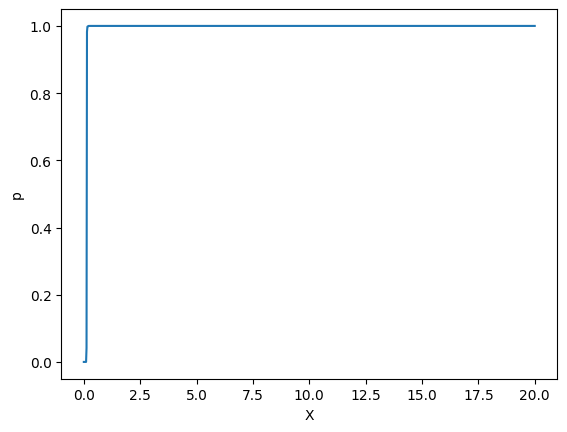

In [113]:
cond_dists[ss_ind].plot_distribution(log=False)

In [114]:
np.sum(cond_dists[ss_ind].pdf * cond_dists[ss_ind].dx)

1.0000000000000002

### marginalising

In [115]:
env_probs = pd.read_csv('env_probs.csv')
nfull = len(env_probs['p'])
env_probs = env_probs[env_probs.p != 0]
np.sum(env_probs)

x       60750.000000
y         182.250000
p           1.000000
dens     1928.571419
dtype: float64

In [116]:
cdf_array = np.empty((env_probs.shape[0], len(cond_dists[0].cdf)))
for i in range(len(cond_dists)):
    cdf_array[i, :] = cond_dists[i].cdf

In [117]:
p_array = np.array(env_probs['p'])
f_cdf = np.sum(cdf_array * p_array[:, np.newaxis], axis=0)

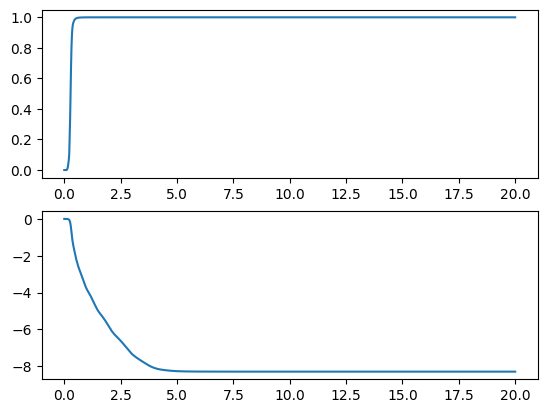

In [118]:
x_num = len(f_cdf)
X = np.linspace(min(cond_dists[0].X), max(cond_dists[0].X), num=x_num)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(X, f_cdf)
plt.subplot(2, 1, 2)
plt.plot(X, np.log10(1-f_cdf))
plt.show()

### get annual marginal dist

In [119]:
lamda = 100  # average number of storms per year
cdf_an = np.exp(-lamda*(1-f_cdf))

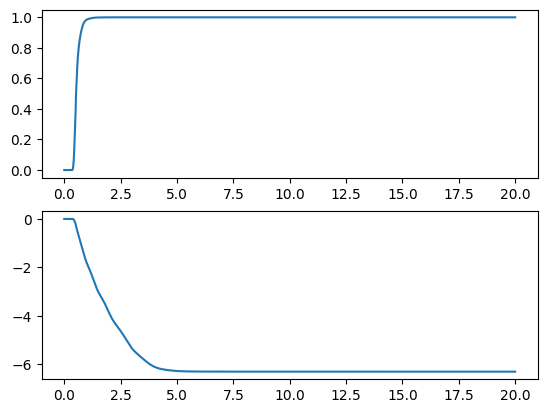

In [120]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(X, cdf_an)
plt.subplot(2, 1, 2)
plt.plot(X, np.log10(1-cdf_an))
plt.show()

### getting return level from annual dist

In [121]:
def return_level(period: int, cdf: np.ndarray):
    """gives return level for given period and numeric cdf

    Args:
        period (int): desired return period
        cdf (np.ndarray): emprical cdf

    Returns:
        float: return value
    """
    p = 1 - 1 / period
    diffs = np.abs(p - cdf_an)
    rp = X[np.where(diffs == np.min(diffs))]
    return float(rp)

In [122]:
period = 100  # years
rp = np.round(return_level(period, cdf_an),3)
rp

1.081

### getting marginal 3 hour max density

In [123]:
dx = X[1] - X[0]
mids = (X[1:] + X[:-1]) / 2
f_pdf = np.diff(f_cdf)/dx
f_pdf = f_pdf/(np.sum(f_pdf * dx))
sum(f_pdf * dx)

0.9999999999999996

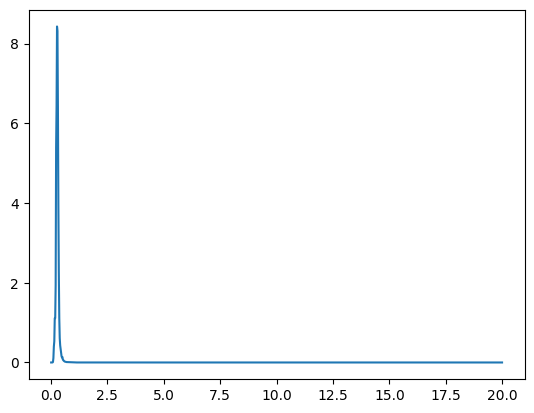

In [124]:
plt.figure()
plt.plot(mids, f_pdf)
plt.show()

In [125]:
def eval_pdf(x: np.ndarray, mids: np.ndarray, pdf: np.ndarray):
    abs_diffs = np.abs(mids-x)
    close_mid_ind = np.where(abs_diffs == np.min(abs_diffs))
    return pdf[close_mid_ind]

In [126]:
eval_pdf(.5, mids, f_pdf)

array([0.12553195])

In [127]:
sum(np.round(X,3)*cond_dists[9].eval_pdf(np.round(X,3)))

3.980134674568042

In [128]:
np.round(X,3)

array([ 0.   ,  0.02 ,  0.04 ,  0.06 ,  0.08 ,  0.1  ,  0.12 ,  0.14 ,
        0.16 ,  0.18 ,  0.2  ,  0.22 ,  0.24 ,  0.26 ,  0.28 ,  0.3  ,
        0.32 ,  0.34 ,  0.36 ,  0.38 ,  0.4  ,  0.42 ,  0.44 ,  0.46 ,
        0.48 ,  0.501,  0.521,  0.541,  0.561,  0.581,  0.601,  0.621,
        0.641,  0.661,  0.681,  0.701,  0.721,  0.741,  0.761,  0.781,
        0.801,  0.821,  0.841,  0.861,  0.881,  0.901,  0.921,  0.941,
        0.961,  0.981,  1.001,  1.021,  1.041,  1.061,  1.081,  1.101,
        1.121,  1.141,  1.161,  1.181,  1.201,  1.221,  1.241,  1.261,
        1.281,  1.301,  1.321,  1.341,  1.361,  1.381,  1.401,  1.421,
        1.441,  1.461,  1.481,  1.502,  1.522,  1.542,  1.562,  1.582,
        1.602,  1.622,  1.642,  1.662,  1.682,  1.702,  1.722,  1.742,
        1.762,  1.782,  1.802,  1.822,  1.842,  1.862,  1.882,  1.902,
        1.922,  1.942,  1.962,  1.982,  2.002,  2.022,  2.042,  2.062,
        2.082,  2.102,  2.122,  2.142,  2.162,  2.182,  2.202,  2.222,
      

### getting conditioned density

In [129]:
rp_cond_theta = np.empty(len(cond_dists))
for i in range(len(cond_dists)):
    rp_cond_theta[i] = cond_dists[i].eval_pdf(np.array([rp]))

In [130]:
rp_marg = np.tile(eval_pdf(rp, mids, f_pdf), len(cond_dists))

In [131]:
dens_quotient = rp_cond_theta / rp_marg

In [132]:
f_theta_r = np.array(env_probs['dens']) * dens_quotient
p_theta_r = np.array(env_probs['p']) * dens_quotient

### checking integrates to 1

In [133]:
sum(p_theta_r) 

0.99999999509109

In [134]:
sum(env_probs['p'])  # should match above

0.999999995000119

### fill in with 0s

In [135]:
f_theta_r

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.57374954e-56, 6.97442889e-56, 4.74979102e-55])

In [136]:
f_theta_r[60]

0.0

In [137]:
f_theta_r_w0 = np.tile(0.0, nfull)
f_theta_r_w0[env_probs.index] = f_theta_r
f_theta_r_w0

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.57374954e-56, 6.97442889e-56, 4.74979102e-55])

### write conditioned density to csv

In [138]:
np.savetxt('/home/speersm/GitHub/environment-modelling/data/cond_dens.csv', f_theta_r_w0, delimiter = '')
np.savetxt('cond_dens.csv', f_theta_r_w0, delimiter = ',')

## getting probabibilities of failure plots

In [139]:
rc = rp

In [140]:
rp

1.081

In [141]:
eval_pdf(rc, cond_dists[200].mids, cond_dists[200].pdf)

array([0.])

In [142]:
fail_ps = np.empty(len(cond_dists))
for i_c, c in enumerate(cond_dists):
    fail_ps[i_c] = 1-eval_pdf(rc, X, cond_dists[i_c].cdf)

In [143]:
fail_ps_full = np.tile(0.0, nfull)
fail_ps_full[env_probs.index] = fail_ps

In [144]:
np.savetxt('/home/speersm/GitHub/environment-modelling/data/fail_ps.csv', fail_ps_full, delimiter = '')